In [1]:
from loadmodules import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
rcParams['figure.facecolor'] = 'white'

In [3]:
dir = './'
simulation_list = [directory for directory in os.listdir(dir) if 'lvl4_cfea_fid' in directory]
print(simulation_list)

['Au06_lvl4_cfea_fiducial', 'Au22_lvl4_cfea_fiducial', 'Au28_lvl4_cfea_fiducial', 'Au24_lvl4_cfea_fiducial', 'D07_lvl4_cfea_fiducial', 'D04_lvl4_cfea_fiducial', 'D10_lvl4_cfea_fiducial', 'L10_lvl4_cfea_fiducial', 'Au27_lvl4_cfea_fiducial', 'Au23_lvl4_cfea_fiducial', 'Au18_lvl4_cfea_fiducial', 'L01_lvl4_cfea_fiducial', 'Au26_lvl4_cfea_fiducial', 'Au14_lvl4_cfea_fiducial']


In [6]:
compare_Itid = []
compare_time_tid = []
compar_mlostsh = []
compare_time = []

In [14]:
# Load simulation data
ii=13
snapshot = 127
print('Loading simulation:', simulation_list[ii], ' snapshot: ', snapshot)
s = gadget_readsnap(snapshot,dir+simulation_list[ii]+'/output', hdf5=True, onlyHeader=True)

# Load shock evolution data
data = np.loadtxt(dir+simulation_list[ii]+'/output/clusterevolution.txt')

# Extract data
time = data[:,0]
init_mass = data[:,1]
mass_evo = data[:,2]
rh_evo = data[:,3]
mlost_sh = data[:,4]
mlost_ev = data[:,5]
tensor_eigenvalues = data[:,6:9]
full_tensor = data[:,9:15]
integrating_flag = data[:,15:21]
tidal_heating = data[:,21]

# Convert tensor data to Gyr^-2
gyr = 3.15576e16 # in s
pc = 3.085e18 # in cm
unit_time = s.parameters['UnitLength_in_cm']/s.parameters['UnitVelocity_in_cm_per_s']
h = s.parameters['HubbleParam']
convert_factor = h**2/time**3 * (gyr/unit_time)**2 # to Gyr^-2
mass_factor = 1e10/h # to Msun
length_factor = s.parameters['UnitLength_in_cm']/pc/h # to pc

# Convert time column to Gyr
lb_time_gyr = s.cosmology_get_lookback_time_from_a(time, is_flat=True)
time_gyr = s.cosmology_get_lookback_time_from_a(1e-5, is_flat=True) - s.cosmology_get_lookback_time_from_a(time, is_flat=True)

tidal_strength = h**2/time**3 * (1/unit_time)**2 * (tensor_eigenvalues[:,0] + 0.333*np.abs(tensor_eigenvalues[:,0] + tensor_eigenvalues[:,1] + tensor_eigenvalues[:,2]))
G = 6.6738e-8 # in cm^3 g^-1 s^-2
tidal_radius = (G * (mass_evo * s.parameters['UnitMass_in_g']/h)/tidal_strength)**(1./3.)
tidal_radius = tidal_radius / pc # to pc

tensor_eigenvalues *= convert_factor[:, np.newaxis]
full_tensor *= convert_factor[:, np.newaxis]
tidal_heating *= gyr**2
init_mass *= mass_factor
mass_evo *= mass_factor
rh_evo *= length_factor
mlost_sh *= mass_factor
mlost_ev *= mass_factor
integrating_flag_cumulative = np.any((integrating_flag>0.), axis=1)

unique = np.unique(init_mass)


Loading simulation: Au14_lvl4_cfea_fiducial  snapshot:  127


/tmp/ipykernel_1871579/3909431334.py:37: RuntimeWarning: invalid value encountered in power
  tidal_radius = (G * (mass_evo * s.parameters['UnitMass_in_g']/h)/tidal_strength)**(1./3.)


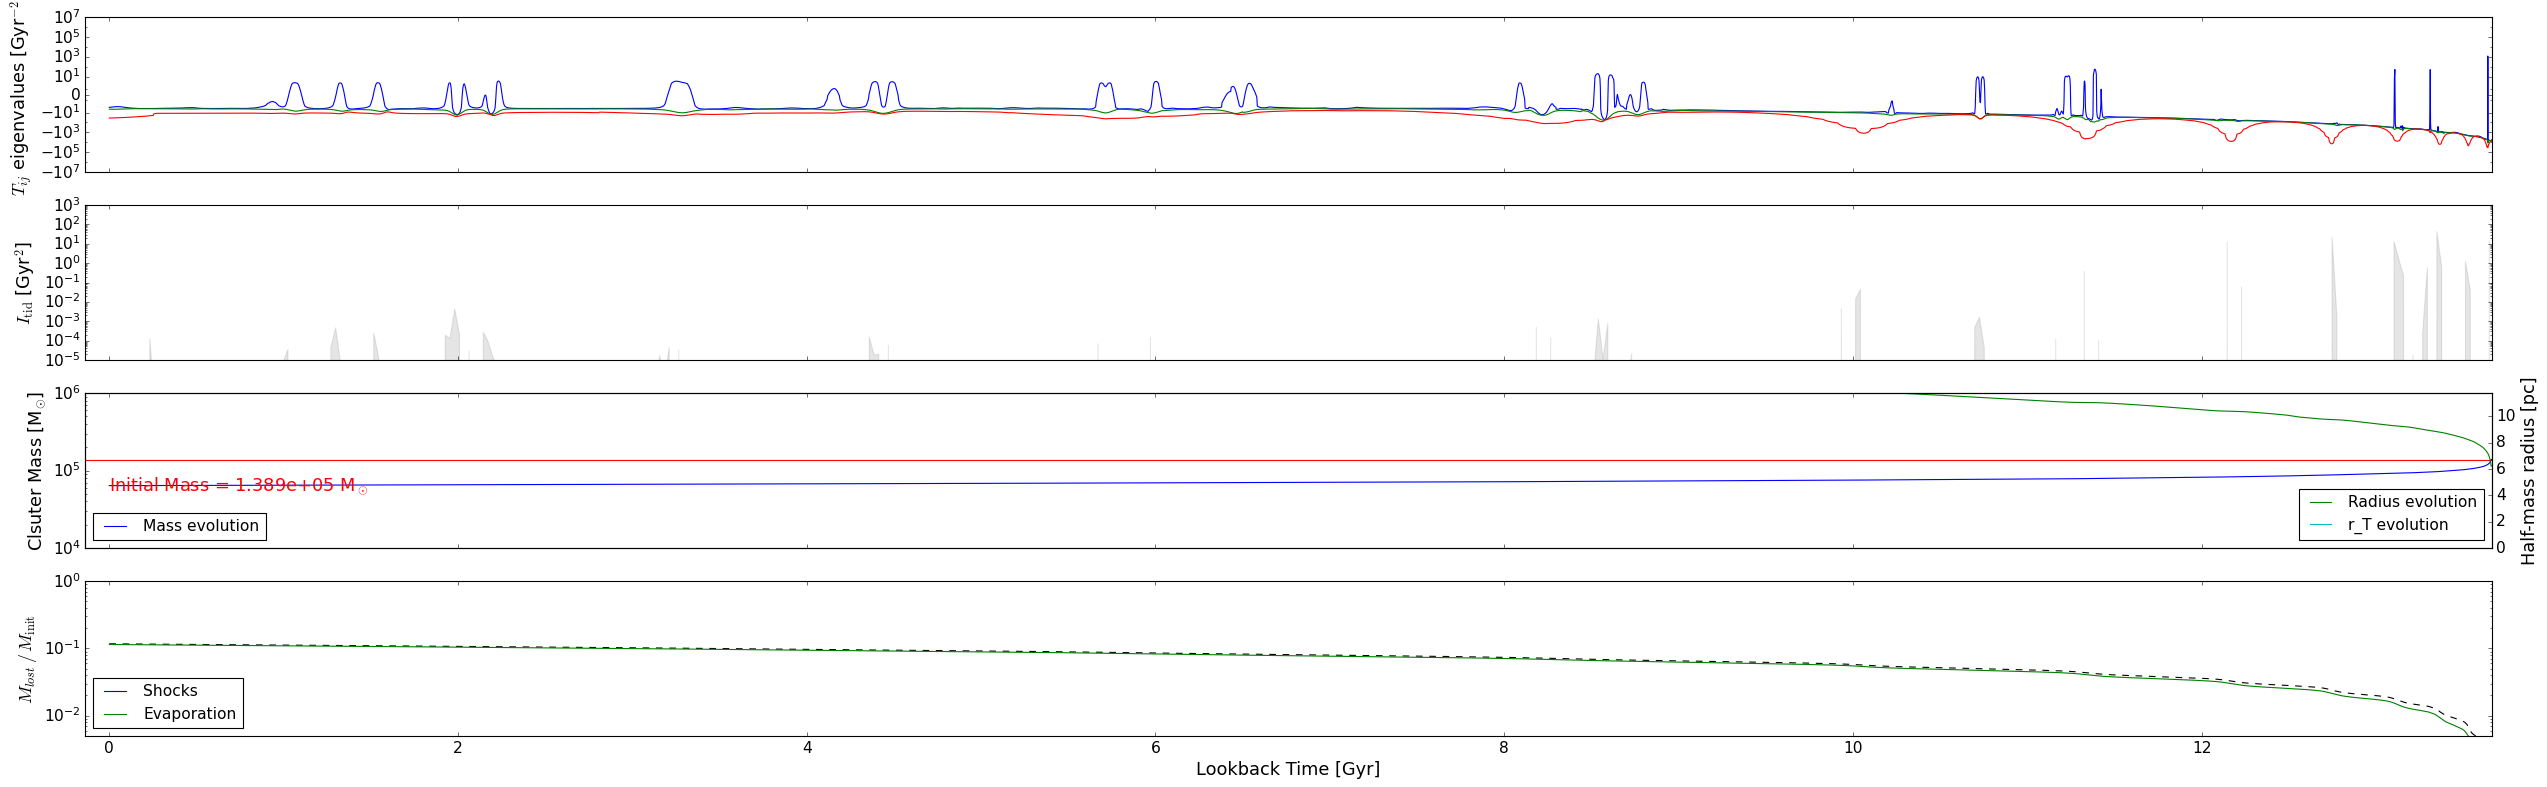

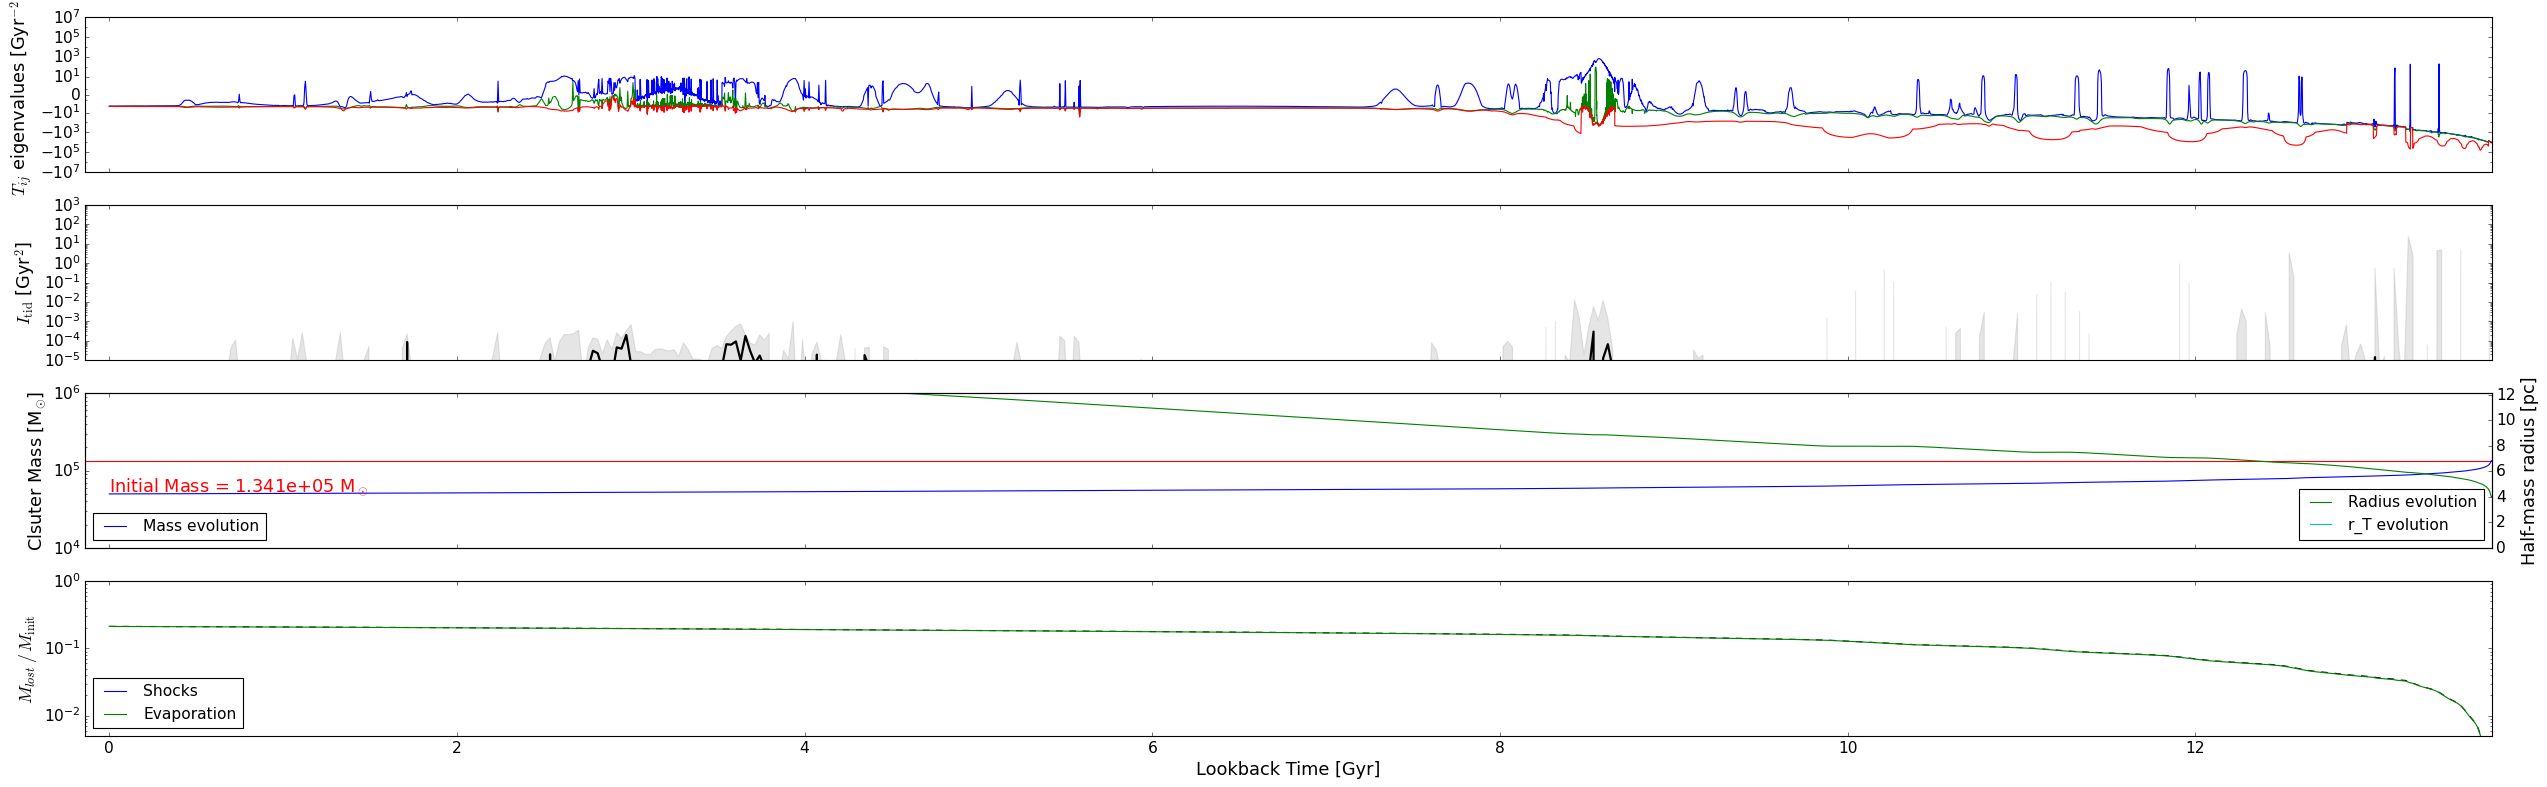

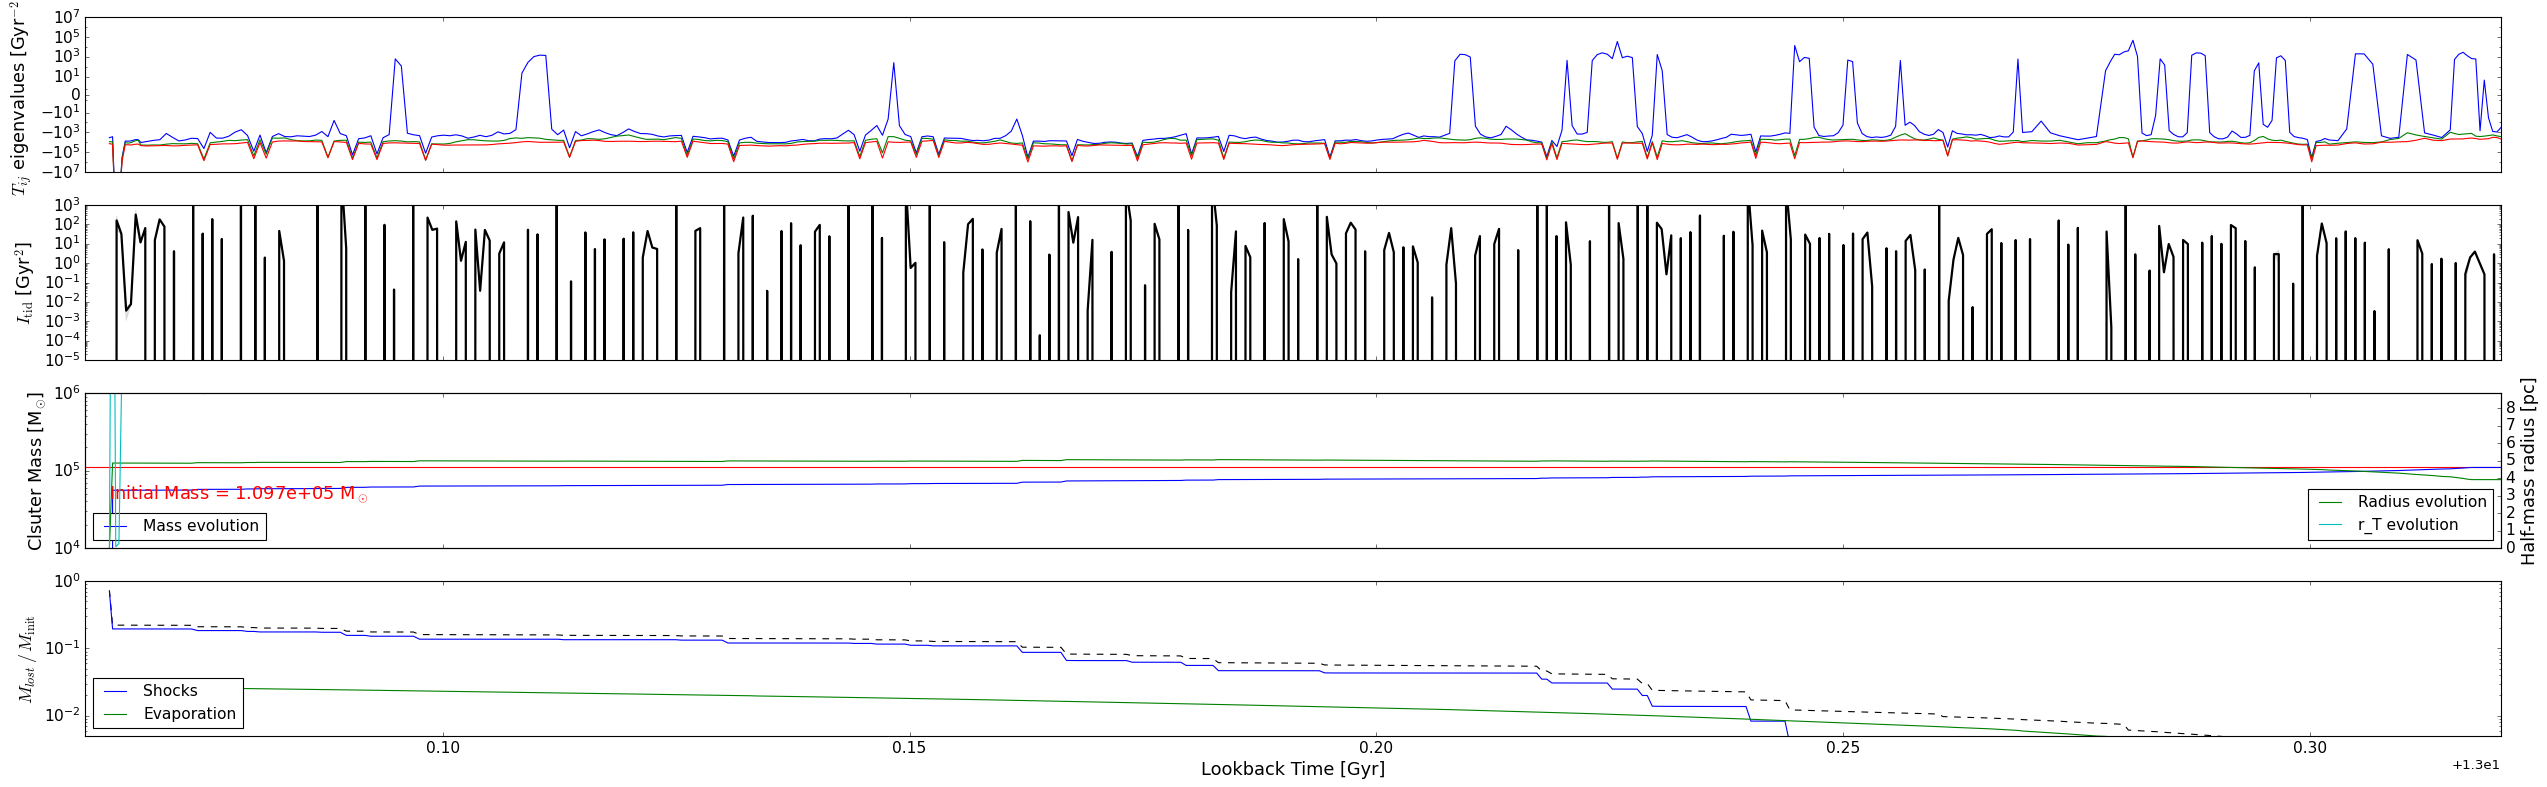

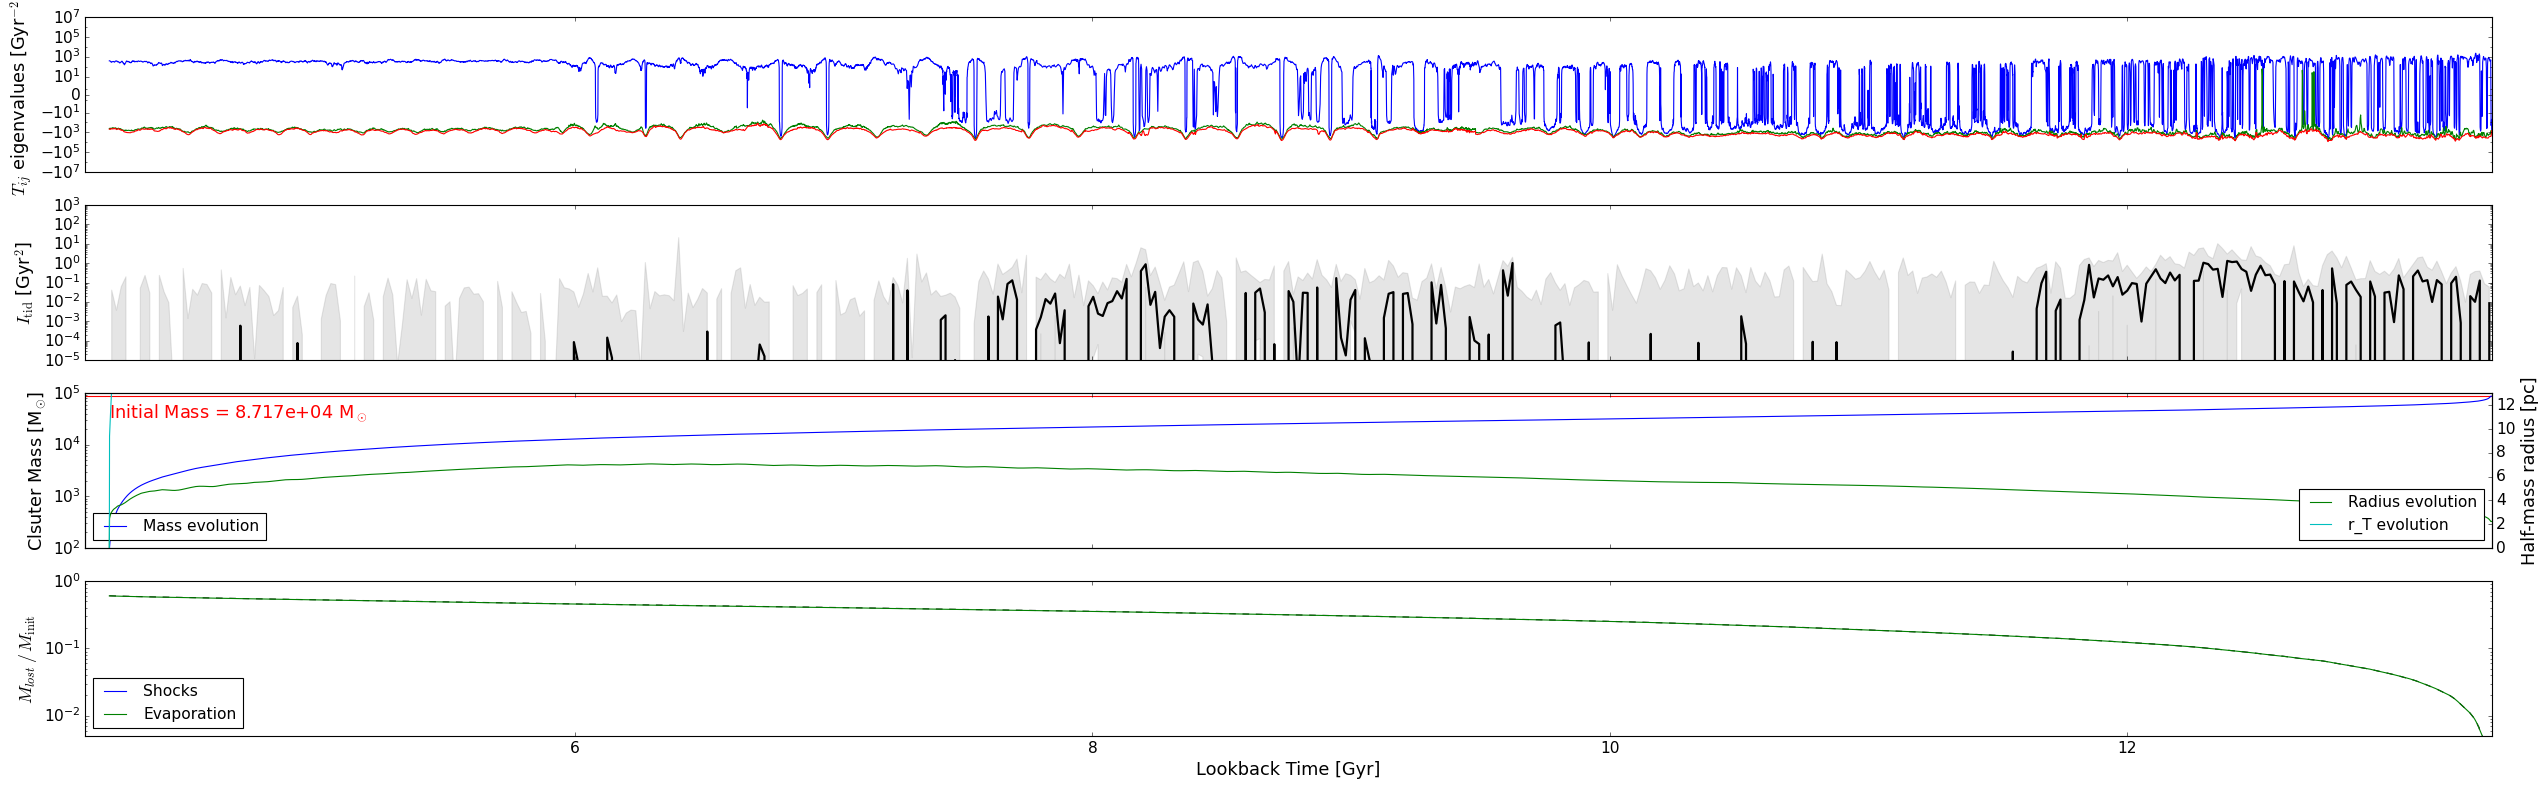

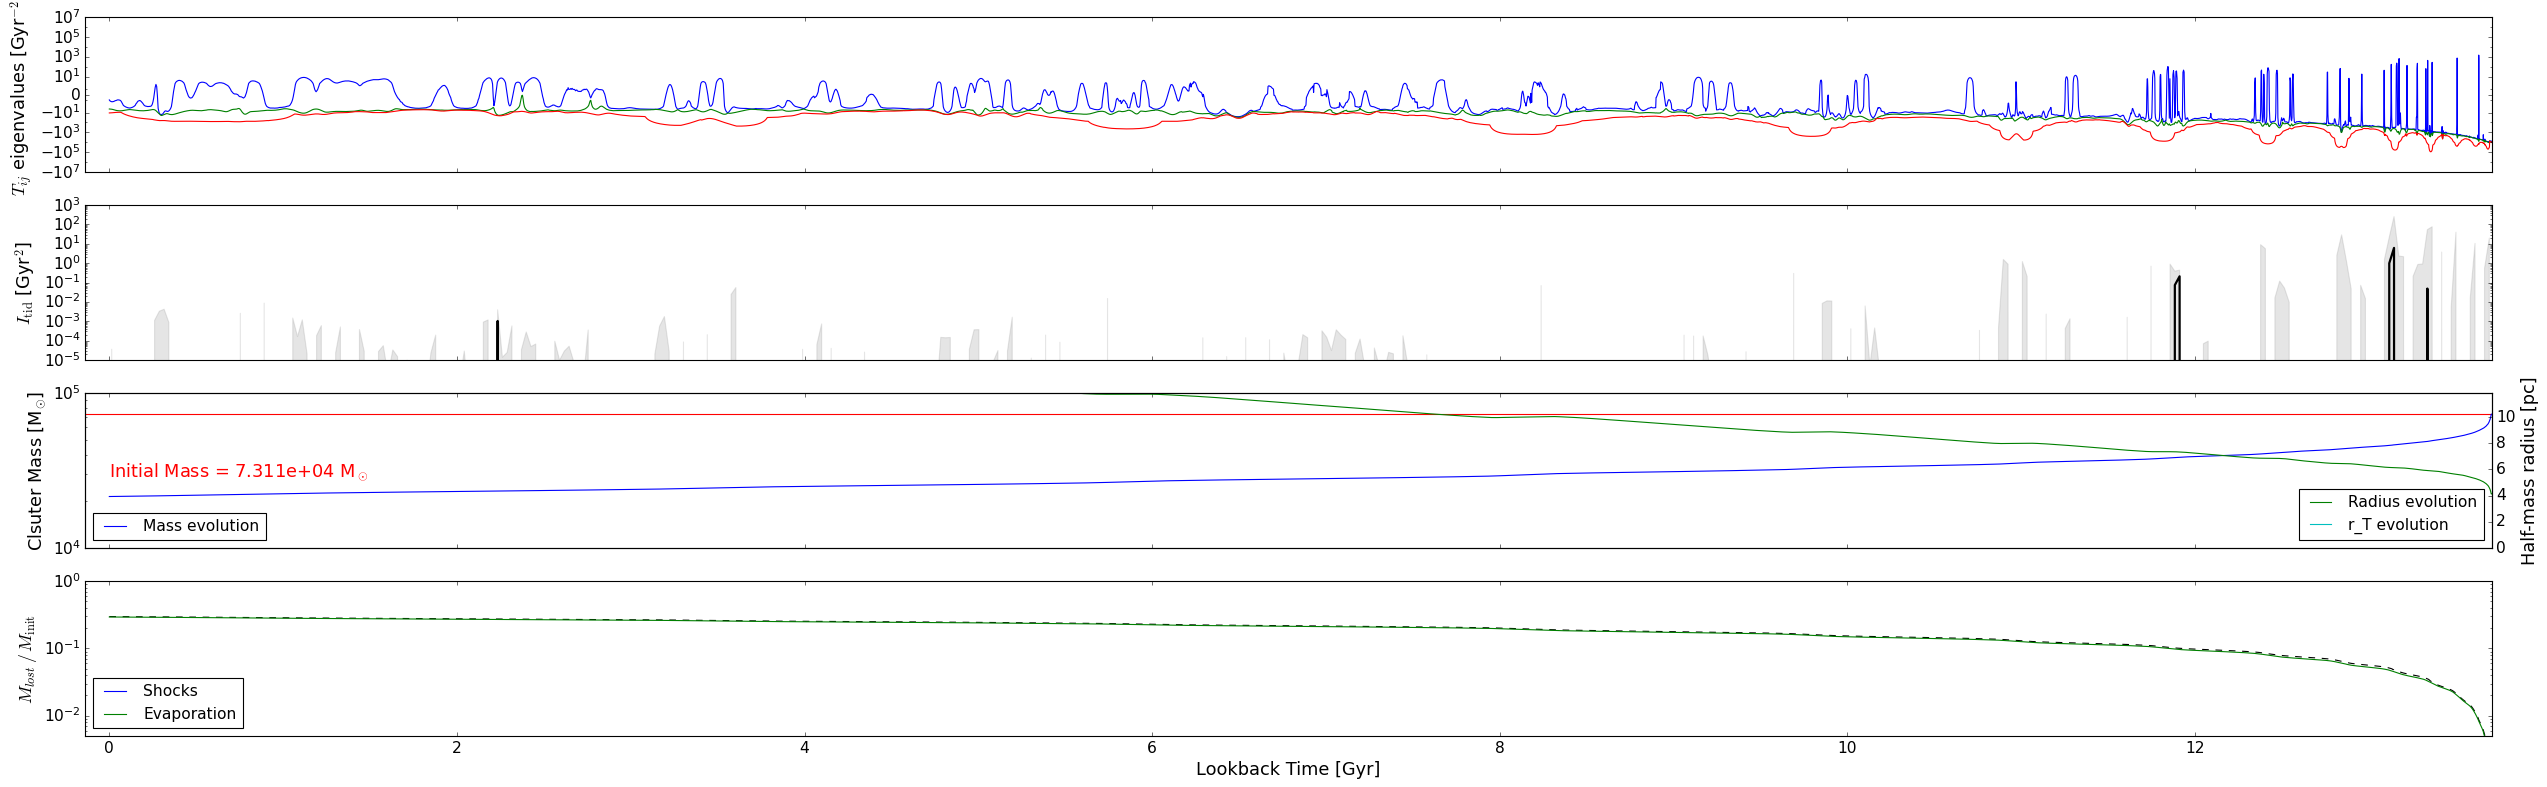

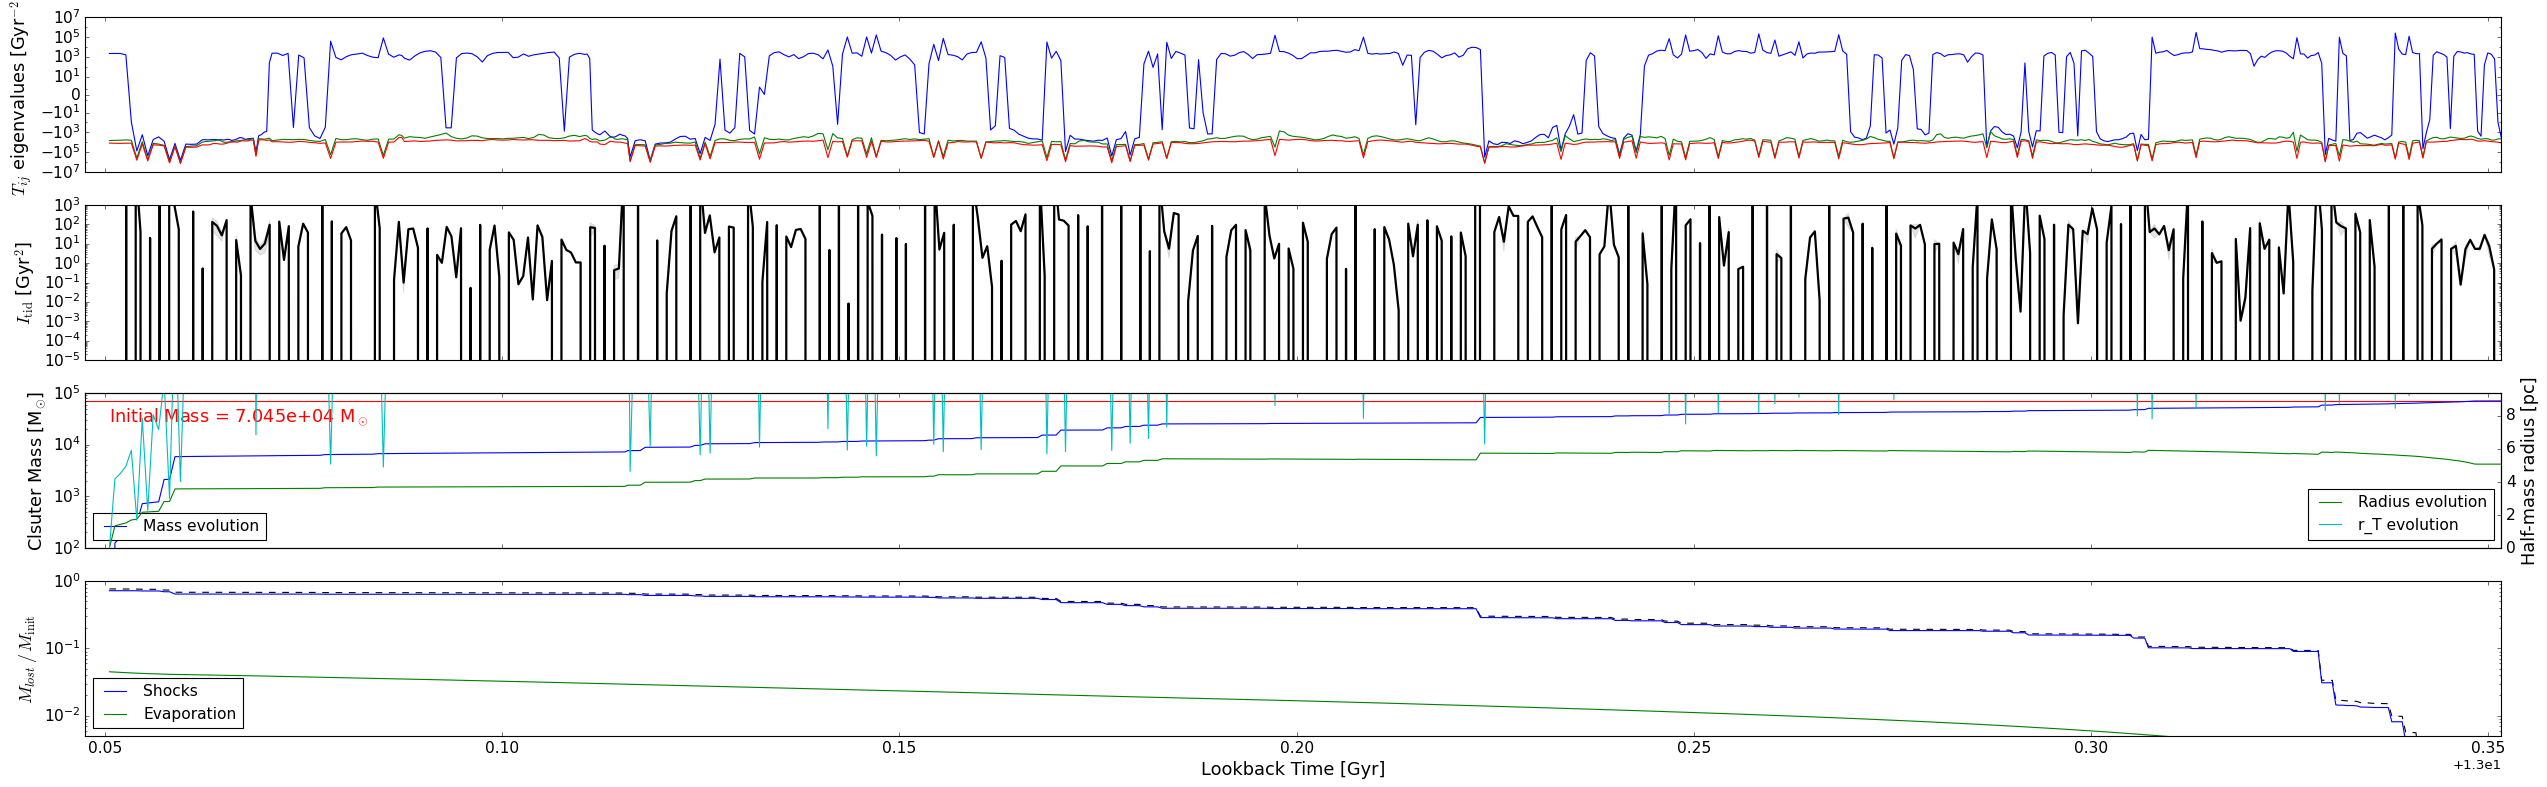

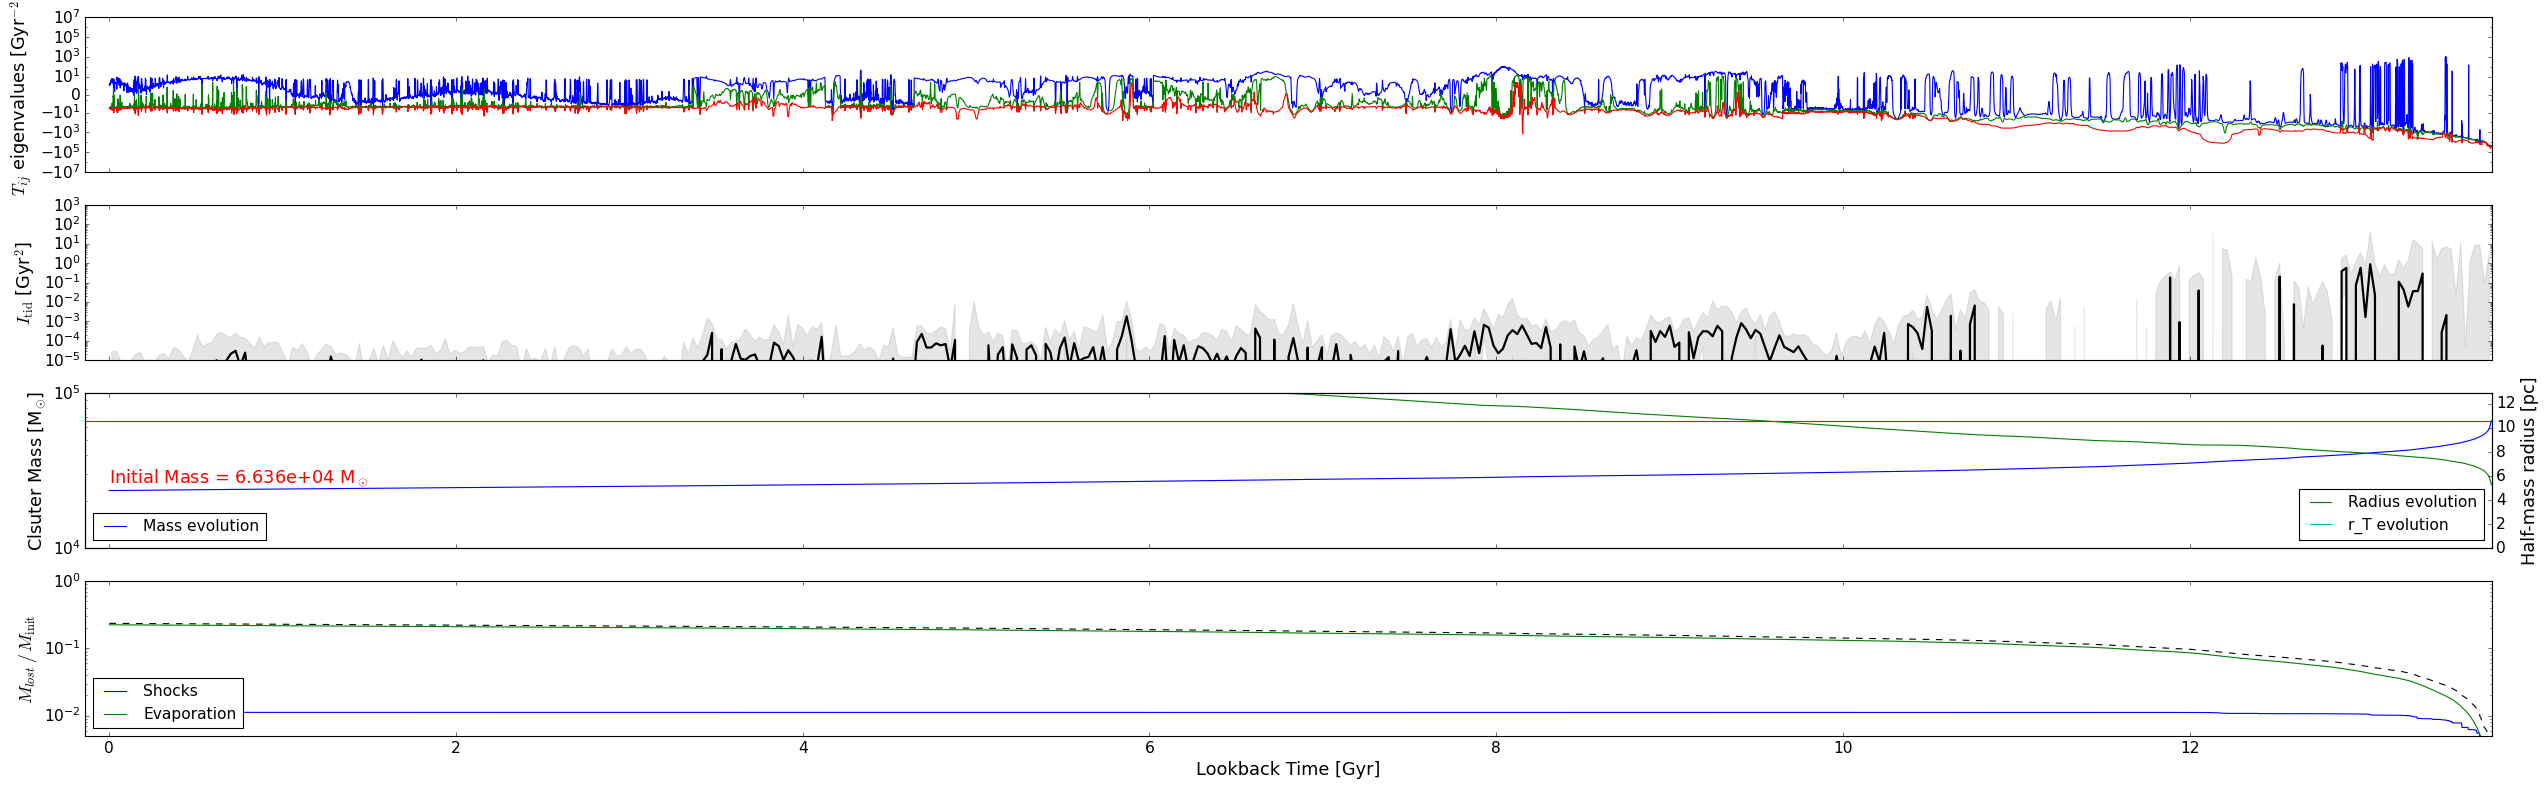

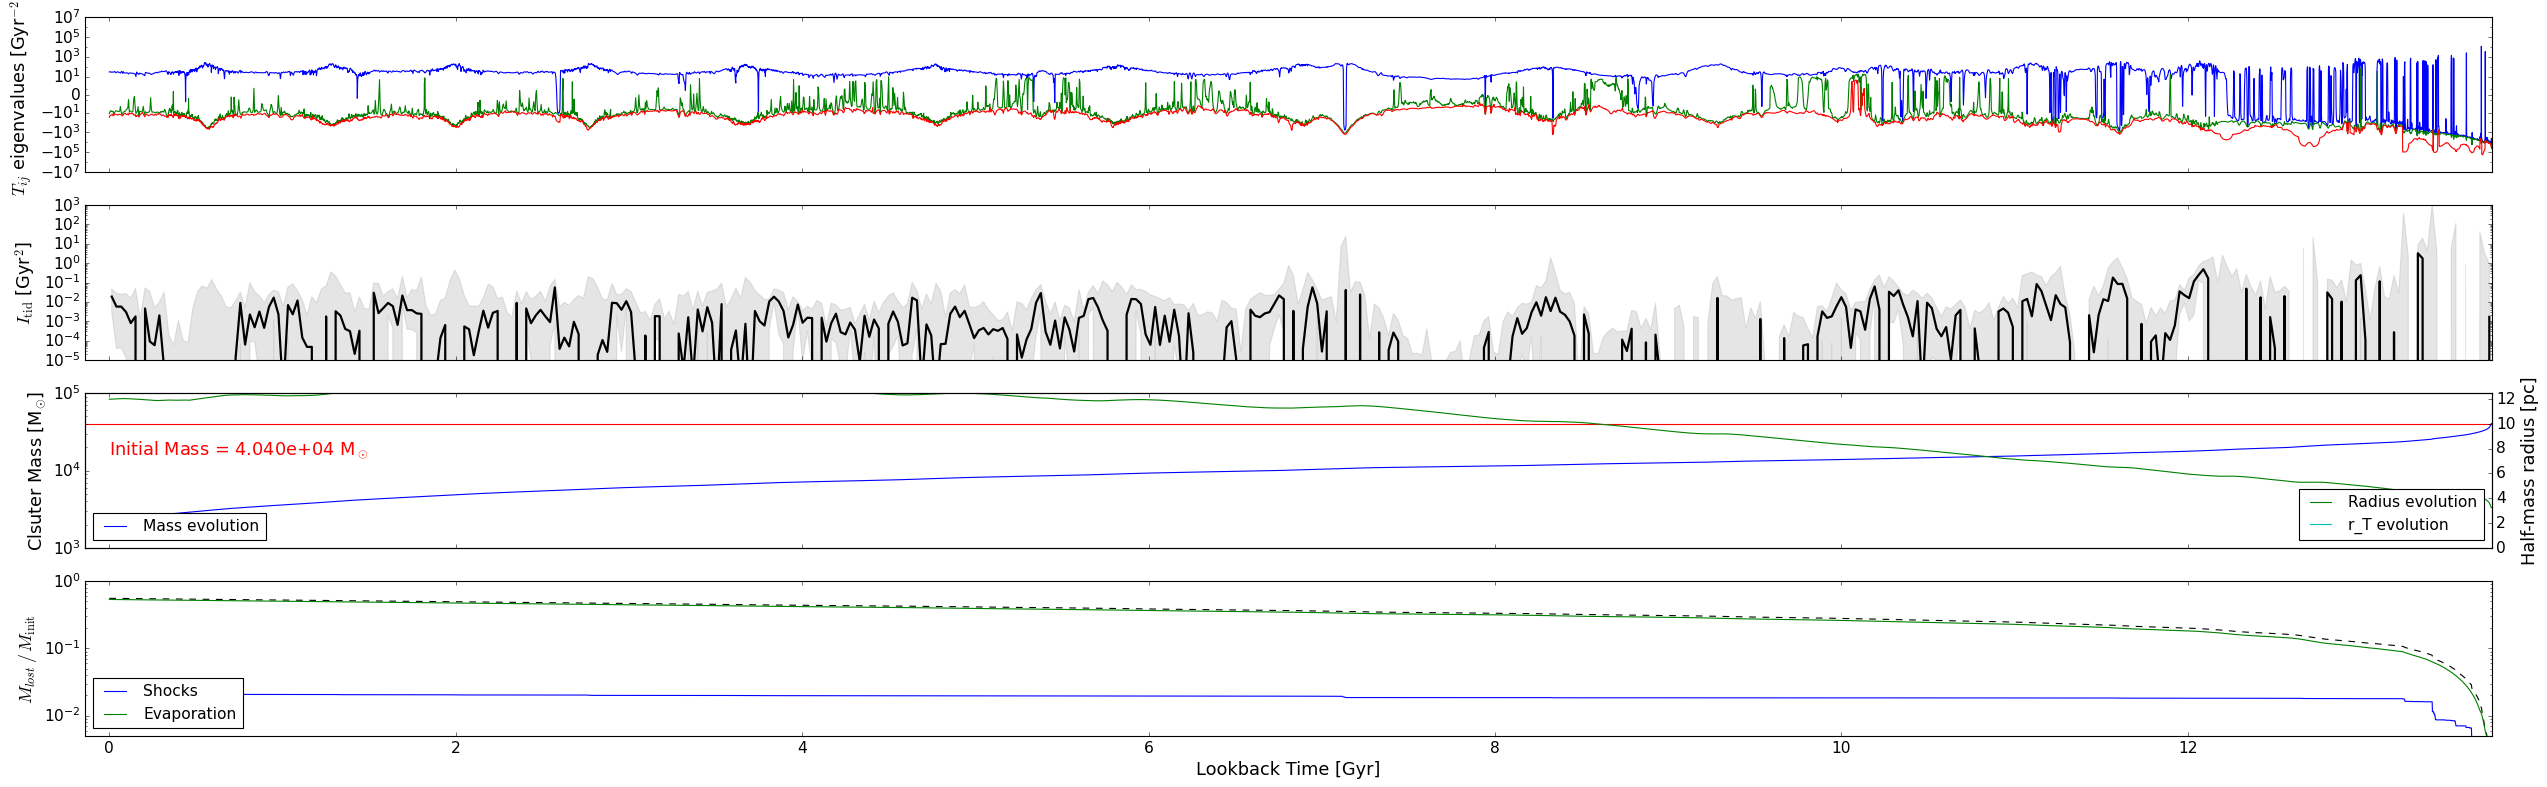

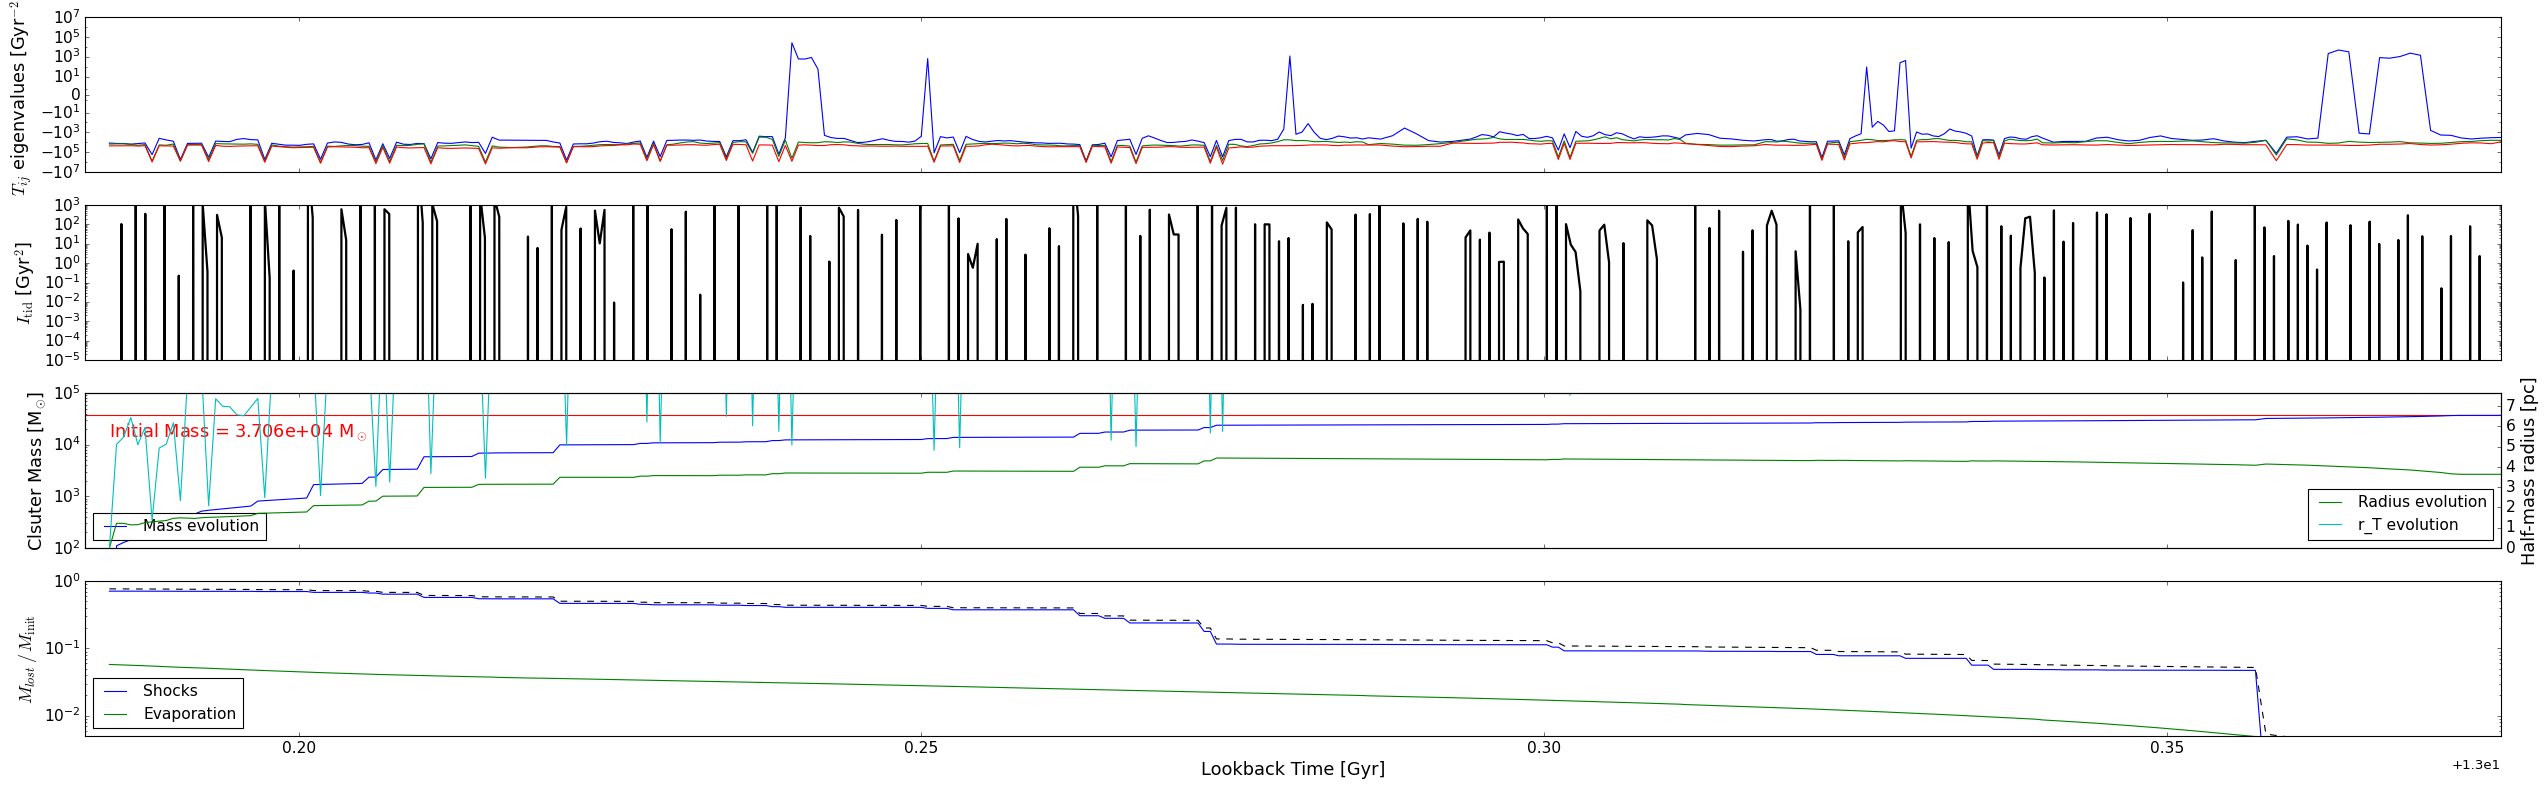

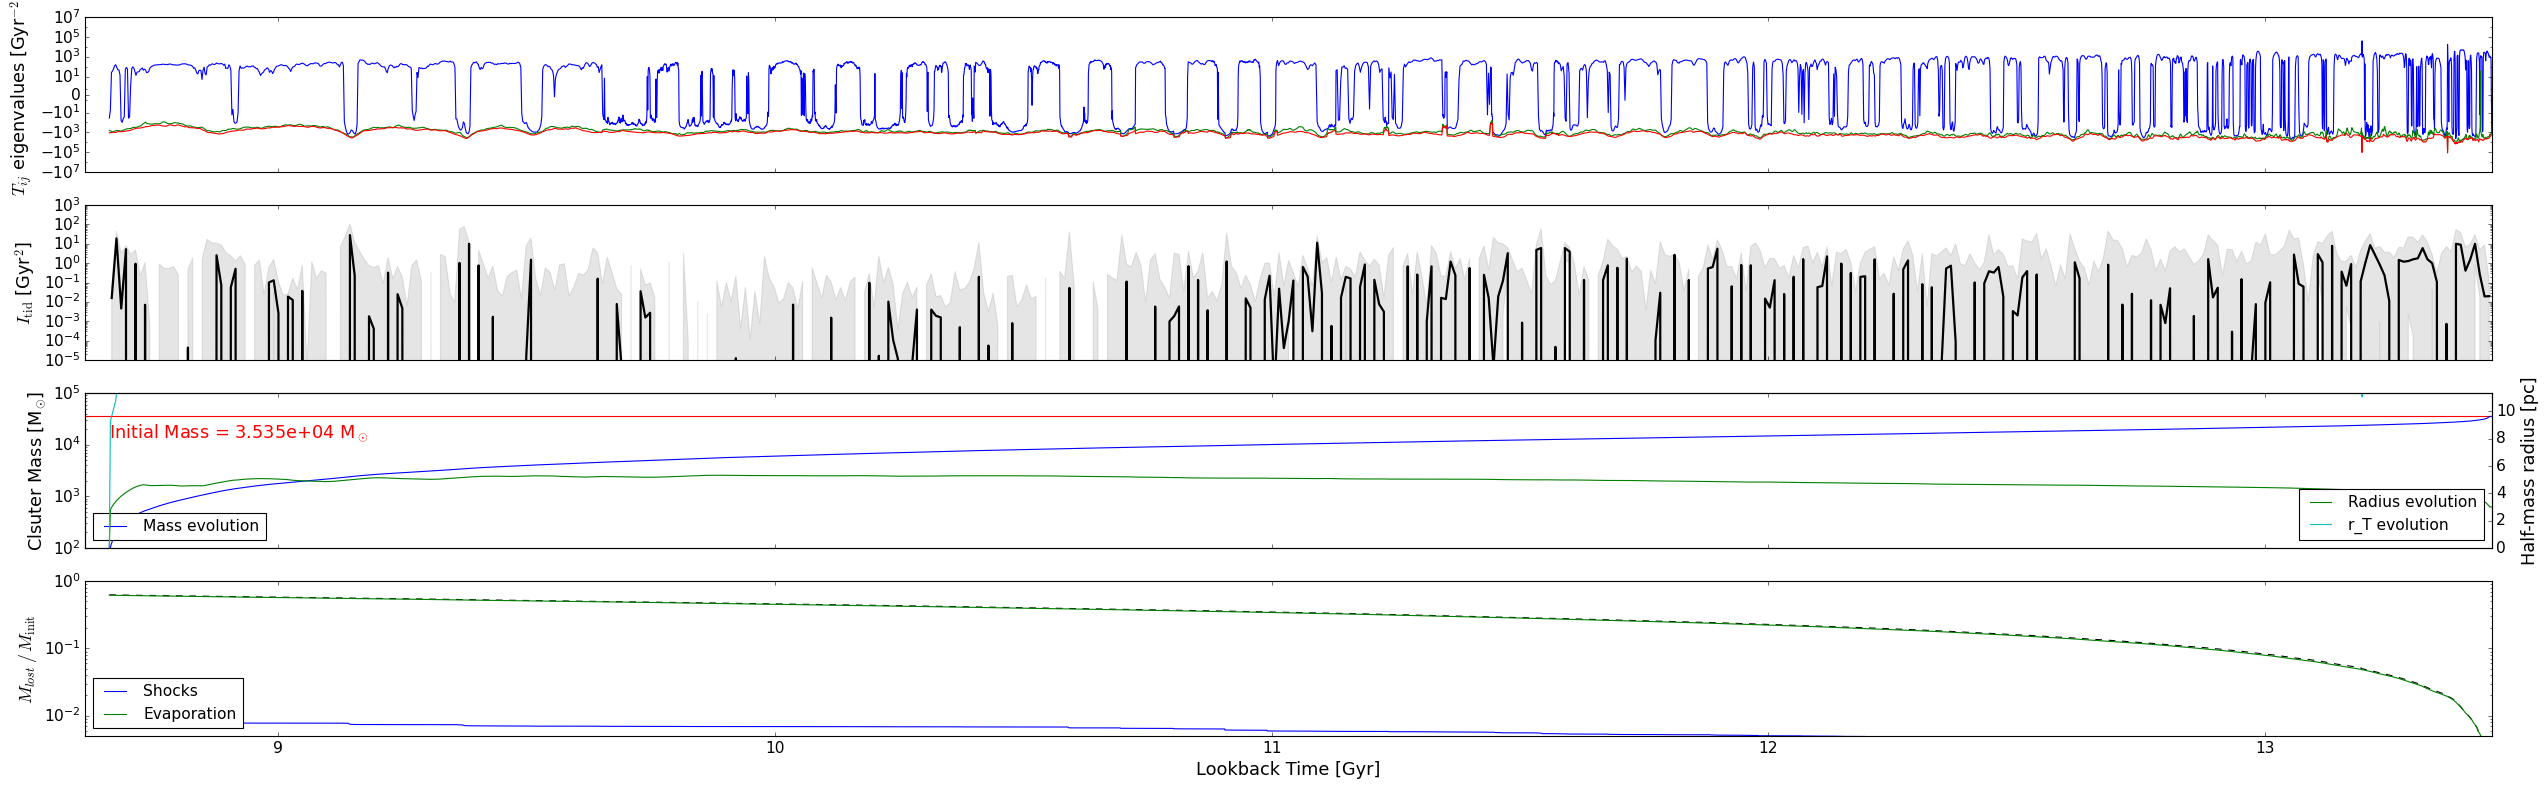

In [16]:
for i in range(10):
# for i in range(len(unique)):
    mass = unique[-1-i]
    mask = init_mass == mass
    # time_unique = time[mask]
    lb_time_gyr_unique = lb_time_gyr[mask]
    tensor_eigenvalues_unique = tensor_eigenvalues[mask]
    integrating_flag_unique = integrating_flag_cumulative[mask]
    tidal_heating_unique = tidal_heating[mask][np.argsort(lb_time_gyr_unique)]

    lb_time_array = np.linspace(lb_time_gyr_unique.min(), lb_time_gyr_unique.max(), 501)
    median_Itid = np.zeros(500)
    quartiles_Itid = np.zeros((500, 2))
    for i in range(500):
        mask_time = (lb_time_gyr_unique[np.argsort(lb_time_gyr_unique)] > lb_time_array[i]) * (lb_time_gyr_unique[np.argsort(lb_time_gyr_unique)] < lb_time_array[i+1])
        if mask_time.sum() > 0:
            median_Itid[i] += np.median(tidal_heating_unique[mask_time])
            quartiles_Itid[i, 0] = np.quantile(tidal_heating_unique[mask_time], .16)
            quartiles_Itid[i, 1] = np.quantile(tidal_heating_unique[mask_time], .84)
    
    compare_Itid.append(median_Itid)
    compare_time_tid.append((lb_time_array[:-1] + lb_time_array[1:])/2)

    fig, ax = plt.subplots(4,1, figsize=(32,10), sharex=True)
    # ax[0].fill_between(lb_time_gyr_unique[np.argsort(lb_time_gyr_unique)][:-1], -1e7, 1e7, where= integrating_flag_unique[1:],
    #                 color='grey', alpha=0.5)#, transform=ax[0].get_xaxis_transform())
    # Omega_tid = np.sqrt(1./3. * np.abs(tensor_eigenvalues_unique[np.argsort(lb_time_gyr_unique)][:,0] + tensor_eigenvalues_unique[np.argsort(lb_time_gyr_unique)][:,1] + tensor_eigenvalues_unique[np.argsort(lb_time_gyr_unique)][:,2]))
    for i in range(3):
        ax[0].plot(lb_time_gyr_unique[np.argsort(lb_time_gyr_unique)], tensor_eigenvalues_unique[np.argsort(lb_time_gyr_unique), i])
        # ax[0].plot(lb_time_gyr_unique[np.argsort(lb_time_gyr_unique)], Omega_tid, label=r'$\Omega_{\rm{Tidal}}$', c='r')
    
    compare_time.append(lb_time_gyr_unique[np.argsort(lb_time_gyr_unique)])

    ax[0].set_ylim(-1e7, 1e7)
    ax[0].set_yscale('symlog')
    ax[0].yaxis.set_major_locator(ticker.FixedLocator([-1e7, -1e5, -1e3, -1e1, 0, 1e1, 1e3, 1e5, 1e7]))
    ax[0].set_ylabel(r'$T_{ij}$ eigenvalues [Gyr$^{-2}$]', fontsize=16)
    ax[0].tick_params(labelsize=14)
    # sax = ax[0].twiny()
    # sax.set_xlim((1./time_unique.min() - 1.,1./time_unique.max() - 1.))
    # # sax.set_xscale('log')
    # sax.tick_params(labelsize=14)
    # sax.set_xlabel('Redshift', fontsize=16)
    
    # axr = ax[0].twinx()
    ax[1].plot((lb_time_array[:-1] + lb_time_array[1:])/2, median_Itid, c='k', linewidth=2)
    ax[1].fill_between((lb_time_array[:-1] + lb_time_array[1:])/2, quartiles_Itid[:, 1], quartiles_Itid[:, 0], color='gray', alpha=0.2)
    ax[1].set_yscale('log')
    ax[1].set_ylim(1e-5, 1e3)
    ax[1].set_ylabel(r'$I_{\rm{tid}}$ [Gyr$^2$]', fontsize=16)
    ax[1].tick_params(labelsize=14)

    ax[2].text(lb_time_gyr_unique.min(),\
               mass*.4, r'Initial Mass = {:.3e} M$_\odot$'.format(mass), fontsize=16, ha='left', color='r')
    ax[2].tick_params(labelsize=14)
    ax[2].hlines(mass, lb_time_gyr_unique.min()-0.01*(lb_time_gyr_unique.max() - lb_time_gyr_unique.min()), lb_time_gyr_unique.max(), color='r')
    ax[2].plot(lb_time_gyr_unique[np.argsort(lb_time_gyr_unique)], mass_evo[mask][np.argsort(lb_time_gyr_unique)], c='b', label='Mass evolution')
    # ax[2].vlines(lb_time_gyr_unique[(mass_evo[mask]>0)][-1], 1e2, 1e4, color='k', linestyle='--')
    # ax[2].text(lb_time_gyr_unique[(mass_evo[mask]>0)], 2e2, r'$t_{\rm{dis}}$'+' = {:.2f} Gyr'.format(lb_time_gyr_unique[(mass_evo[mask]>0)][-1]), fontsize=16, ha='center', rotation='vertical')
    ax[2].set_yscale('log')
    ax[2].set_ylabel(r'Clsuter Mass [M$_{\odot}$]', fontsize=16)
    axr = ax[2].twinx()
    axr.plot(lb_time_gyr_unique[np.argsort(lb_time_gyr_unique)], rh_evo[mask][np.argsort(lb_time_gyr_unique)], c='g', label='Radius evolution')
    axr.plot(lb_time_gyr_unique[np.argsort(lb_time_gyr_unique)], tidal_radius[mask][np.argsort(lb_time_gyr_unique)], c='c', label='r_T evolution')
    axr.set_ylabel(r'Half-mass radius [pc]', fontsize=16)
    axr.set_ylim(0, rh_evo[np.argsort(lb_time_gyr_unique)].max()*1.5)
    axr.tick_params(labelsize=14)
    axr.legend(fontsize=14, loc='lower right')
    ax[2].legend(fontsize=14, loc='lower left')

    compar_mlostsh.append(mlost_sh[mask][np.argsort(lb_time_gyr_unique)])
    ax[3].plot(lb_time_gyr_unique[np.argsort(lb_time_gyr_unique)], (mlost_sh[mask][np.argsort(lb_time_gyr_unique)]\
                                                               + mlost_ev[mask][np.argsort(lb_time_gyr_unique)])/mass, c='k', linestyle='--')
    ax[3].plot(lb_time_gyr_unique[np.argsort(lb_time_gyr_unique)], mlost_sh[mask][np.argsort(lb_time_gyr_unique)]/mass, label='Shocks')
    ax[3].plot(lb_time_gyr_unique[np.argsort(lb_time_gyr_unique)], mlost_ev[mask][np.argsort(lb_time_gyr_unique)]/mass, label='Evaporation')
    ax[3].set_ylabel(r'$M_{lost} \, / \, M_{\rm{init}}$', fontsize=16)
    ax[3].set_yscale('log')
    ax[3].tick_params(labelsize=14)
    ax[3].set_xlim(lb_time_gyr_unique.min()-0.01*(lb_time_gyr_unique.max() - lb_time_gyr_unique.min()), lb_time_gyr_unique.max())
    ax[3].set_ylim(5e-3, 1e0)
    ax[3].set_xlabel('Lookback Time [Gyr]', fontsize=16)
    ax[3].legend(fontsize=14, loc='lower left')

    plt.tight_layout()
    # plt.savefig('plots/'+simulation_list[ii]+'_cluster_{:.2e}.pdf'.format(mass))
    plt.show()

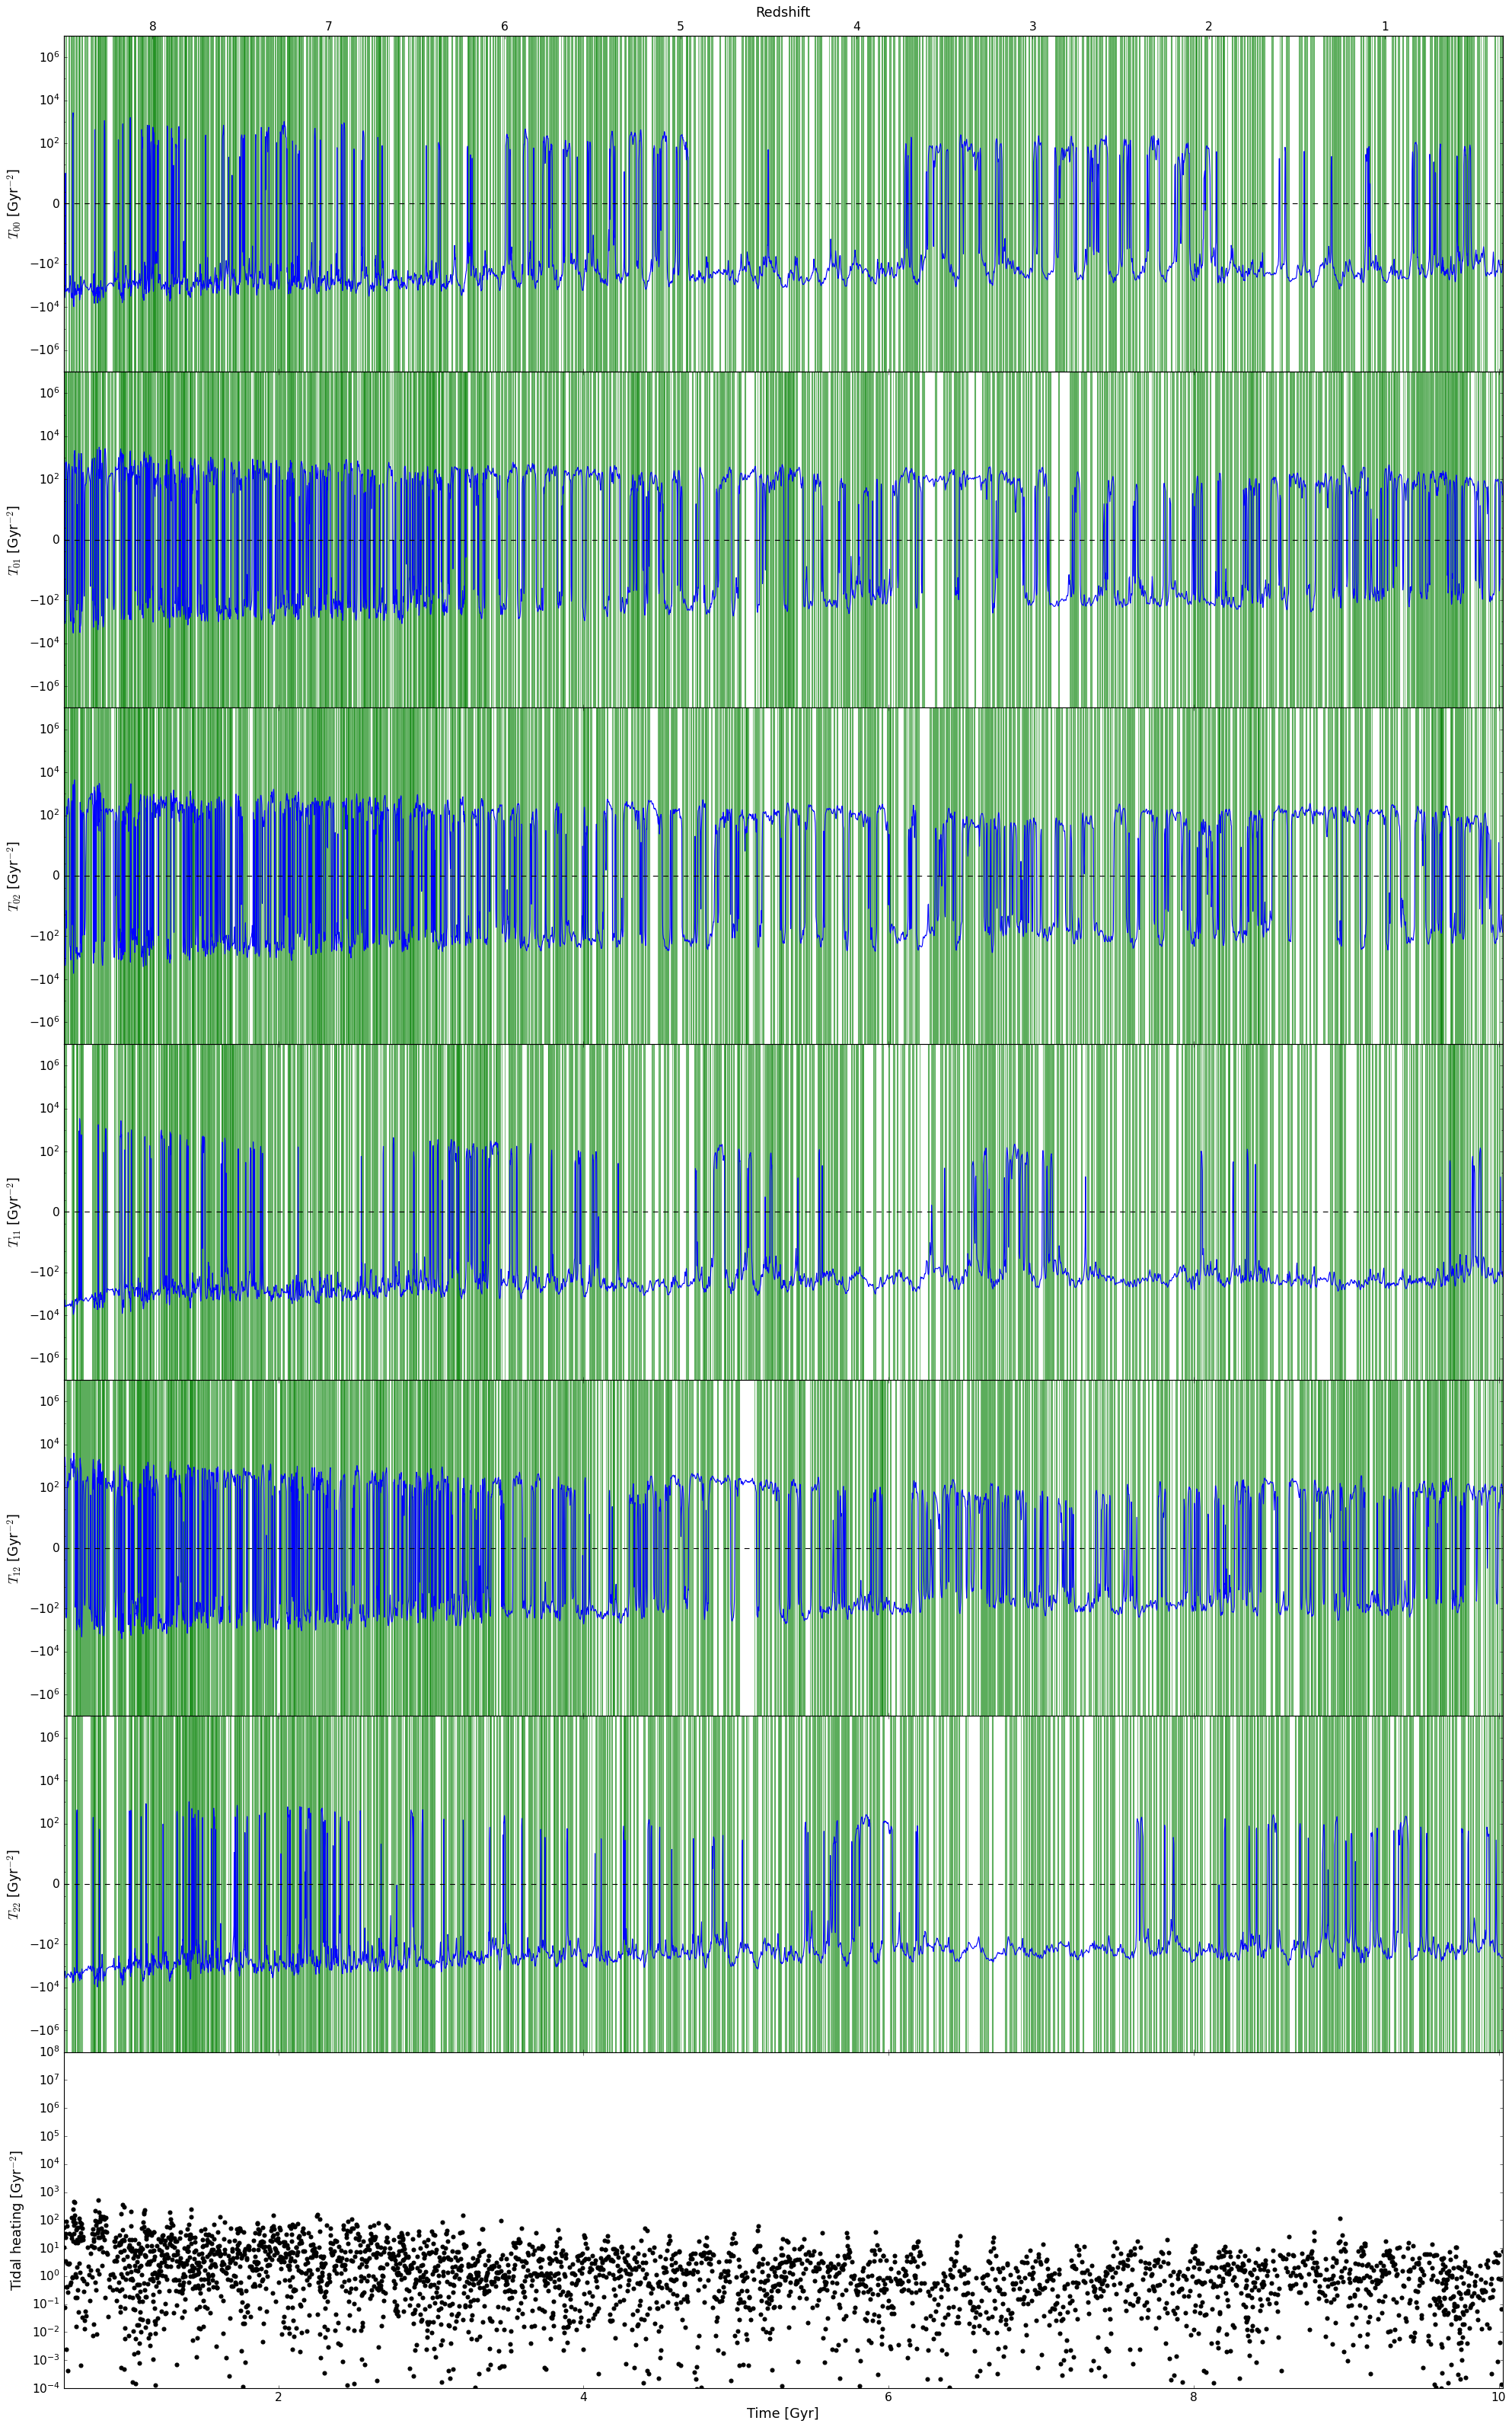

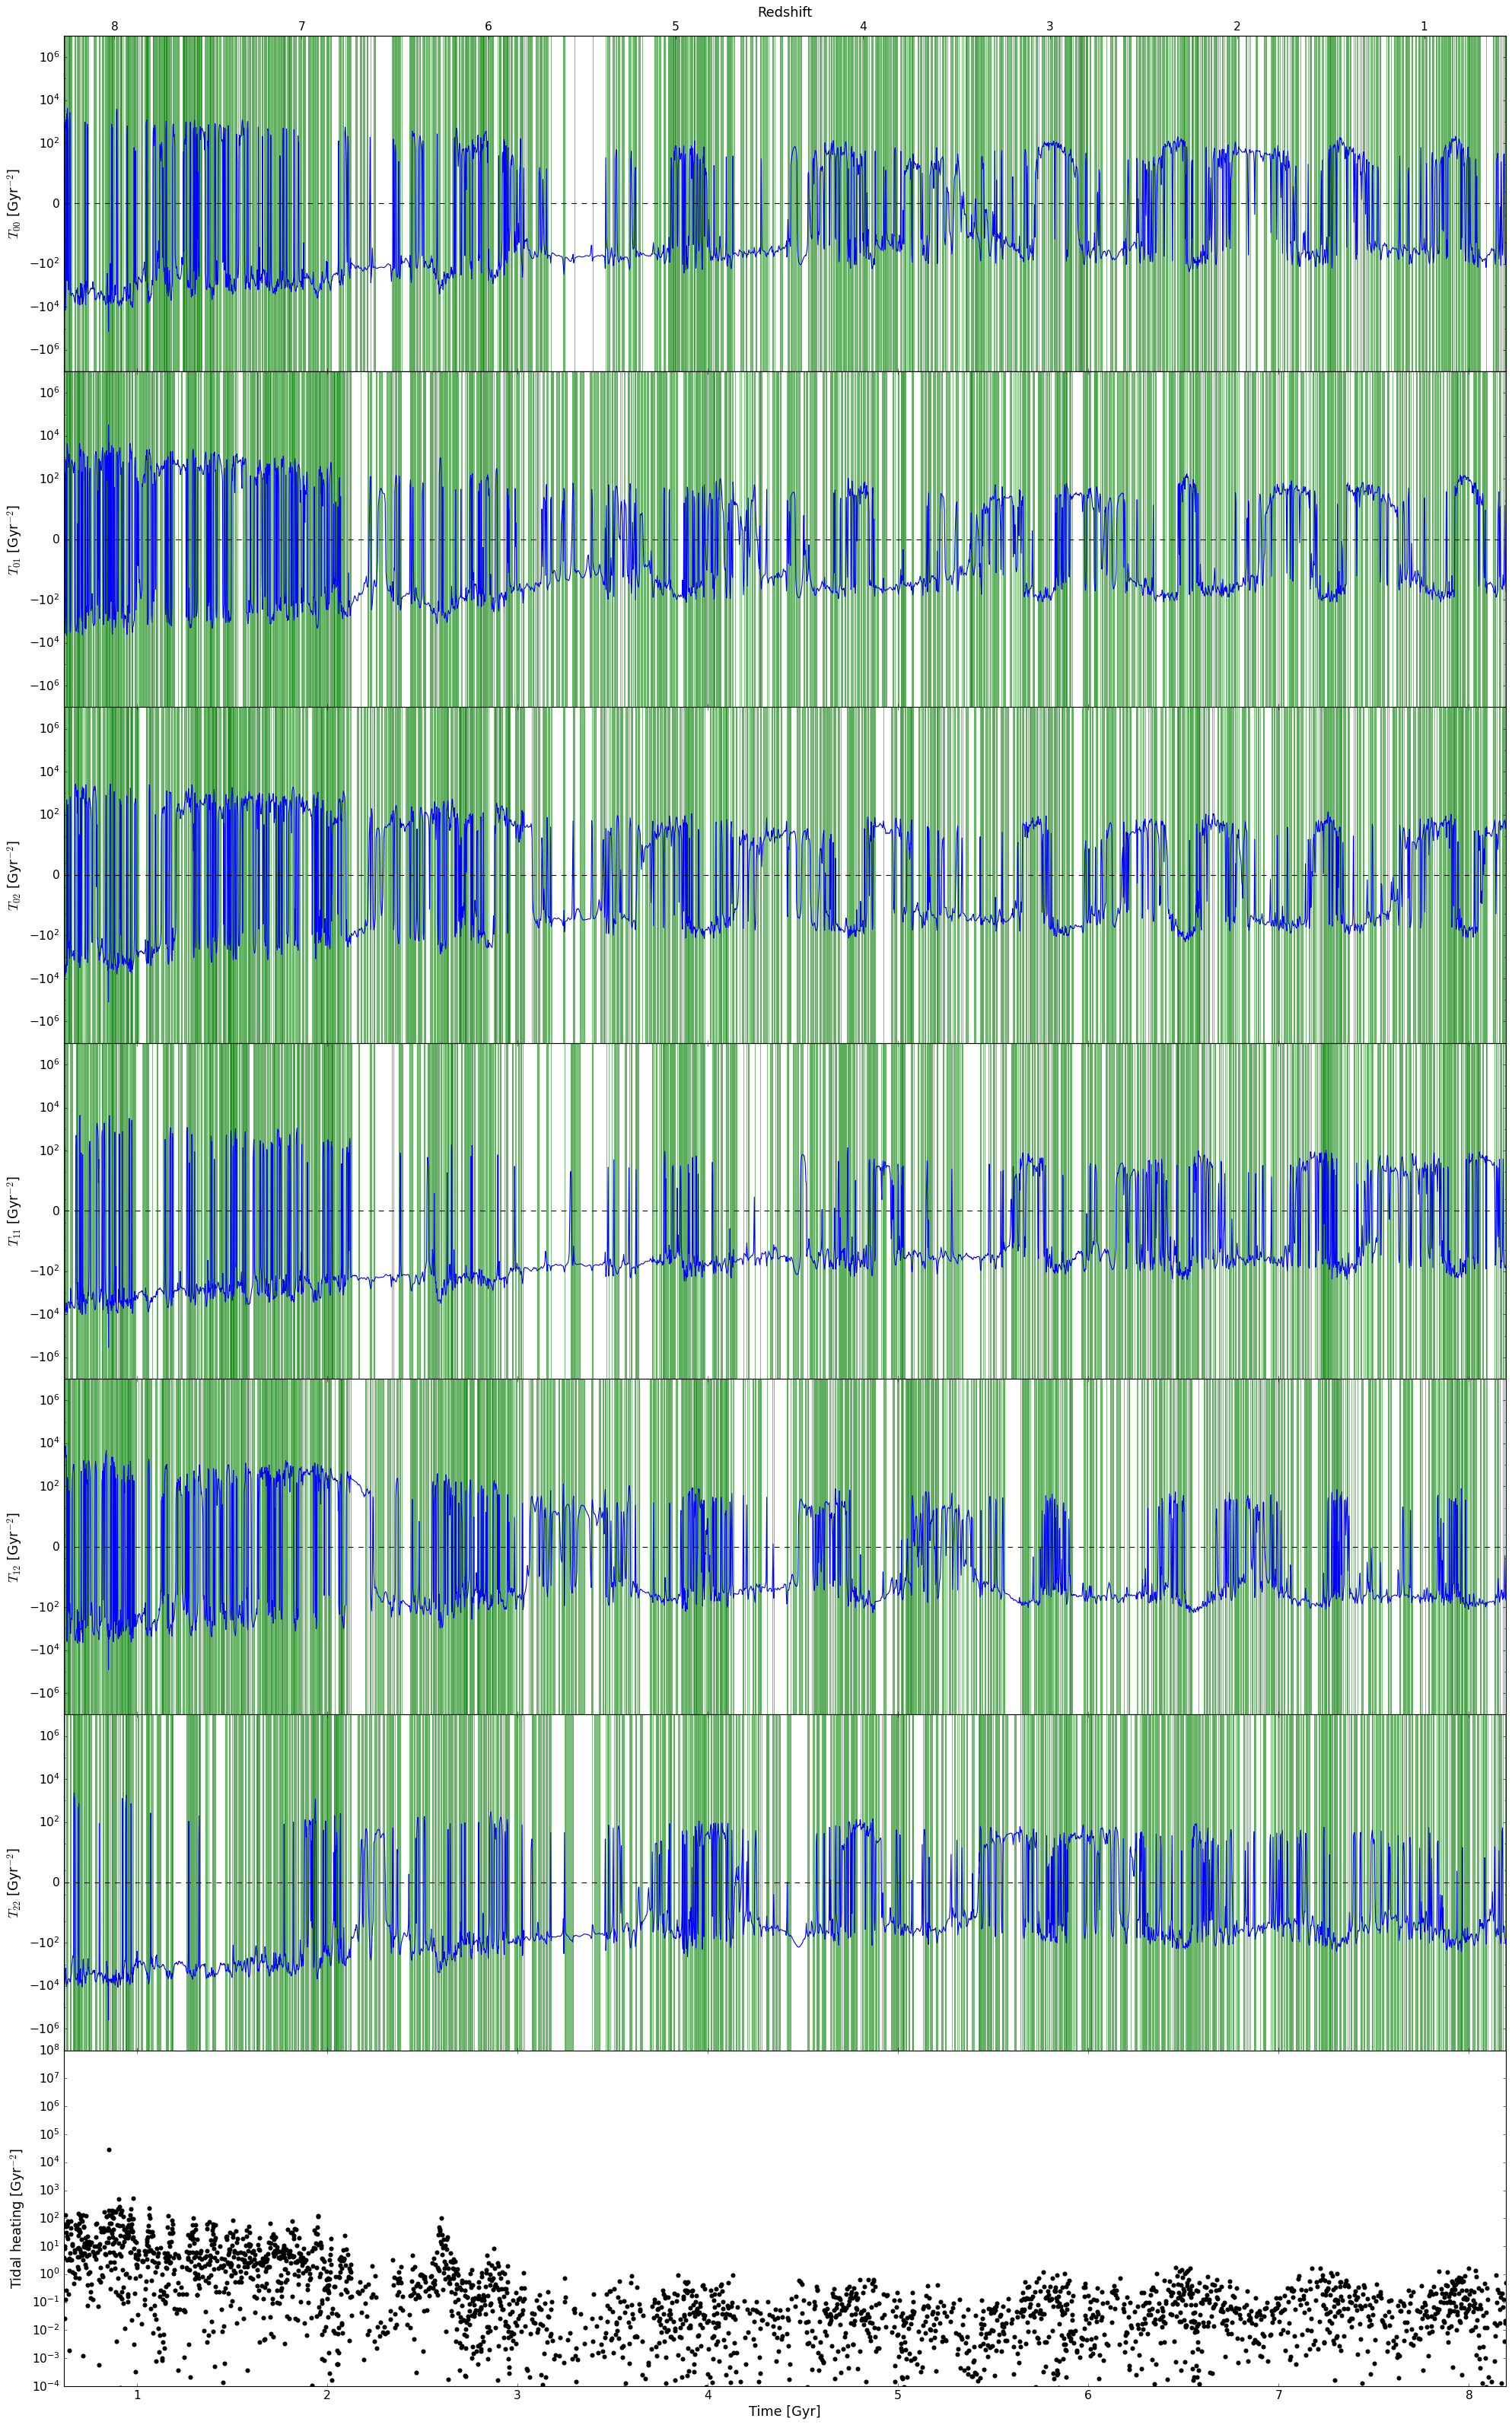

In [10]:
for i in range(2):
# for i in range(len(unique)):
    fig, ax = plt.subplots(7, 1, sharex=True, figsize=(25, 40))
    mass = unique[idx[-1-i]]
    mask = init_mass == mass
    time_gyr_unique = time_gyr[mask]
    full_tensor_unique = full_tensor[mask]
    integrating_flag_unique = integrating_flag[mask][np.argsort(time_gyr_unique)]
    # for i in range(6):
    #     integrating_flag_unique[:-1,i] += integrating_flag_unique[1:,i]
    #     integrating_flag_unique[1:,i] += integrating_flag_unique[:-1,i]
    #     integrating_flag_unique[integrating_flag_unique > 0] = 1
    ax[0].plot(time_gyr_unique[np.argsort(time_gyr_unique)], full_tensor_unique[:,0][np.argsort(time_gyr_unique)])
    ax[0].fill_between(time_gyr_unique[np.argsort(time_gyr_unique)], -1e7, 1e7, where= integrating_flag_unique[:,0]> 0.,
                color='green', alpha=0.5)
    ax[1].plot(time_gyr_unique[np.argsort(time_gyr_unique)], full_tensor_unique[:,1][np.argsort(time_gyr_unique)])
    ax[1].fill_between(time_gyr_unique[np.argsort(time_gyr_unique)], -1e7, 1e7, where= integrating_flag_unique[:,1]> 0.,
                color='green', alpha=0.5)
    ax[2].plot(time_gyr_unique[np.argsort(time_gyr_unique)], full_tensor_unique[:,2][np.argsort(time_gyr_unique)])
    ax[2].fill_between(time_gyr_unique[np.argsort(time_gyr_unique)], -1e7, 1e7, where= integrating_flag_unique[:,2]> 0.,
                color='green', alpha=0.5)
    ax[3].plot(time_gyr_unique[np.argsort(time_gyr_unique)], full_tensor_unique[:,3][np.argsort(time_gyr_unique)])
    ax[3].fill_between(time_gyr_unique[np.argsort(time_gyr_unique)], -1e7, 1e7, where= integrating_flag_unique[:,3]> 0.,
                color='green', alpha=0.5)
    ax[4].plot(time_gyr_unique[np.argsort(time_gyr_unique)], full_tensor_unique[:,4][np.argsort(time_gyr_unique)])
    ax[4].fill_between(time_gyr_unique[np.argsort(time_gyr_unique)], -1e7, 1e7, where= integrating_flag_unique[:,4]> 0.,
                color='green', alpha=0.5)
    ax[5].plot(time_gyr_unique[np.argsort(time_gyr_unique)], full_tensor_unique[:,5][np.argsort(time_gyr_unique)])
    ax[5].fill_between(time_gyr_unique[np.argsort(time_gyr_unique)], -1e7, 1e7, where= integrating_flag_unique[:,5]> 0.,
                color='green', alpha=0.5)
    for i in range(6):
        ax[i].hlines(0, time_gyr_unique.min(), time_gyr_unique.max(), color='k', linestyle='--')

    Itid = tidal_heating[mask][np.argsort(time_gyr_unique)]
    ax[6].scatter(time_gyr_unique[np.argsort(time_gyr_unique)], np.where(Itid>1e8, 5e7, Itid), c='black')

    sax = ax[0].twiny()
    sax.set_xlim((1./time[mask].min() - 1.,1./time[mask].max() - 1.))
    sax.tick_params(labelsize=14)
    # sax.set_xscale('symlog')
    # sax.xaxis.set_major_locator(ticker.FixedLocator(np.concatenate([np.arange(0,10,1), np.arange(10,50,5)])))
    # sax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    sax.set_xlabel('Redshift', fontsize=16)
    ax[0].set_ylabel(r'$T_{00}$ [Gyr$^{-2}$]', fontsize=16)
    ax[1].set_ylabel(r'$T_{01}$ [Gyr$^{-2}$]', fontsize=16)
    ax[2].set_ylabel(r'$T_{02}$ [Gyr$^{-2}$]', fontsize=16)
    ax[3].set_ylabel(r'$T_{11}$ [Gyr$^{-2}$]', fontsize=16)
    ax[4].set_ylabel(r'$T_{12}$ [Gyr$^{-2}$]', fontsize=16)
    ax[5].set_ylabel(r'$T_{22}$ [Gyr$^{-2}$]', fontsize=16)
    for i in range(6):
        ax[i].set(yscale='symlog', ylim=(-1e7, 1e7))
        ax[i].yaxis.set_major_locator(ticker.FixedLocator([-1e6, -1e4, -1e2, 0, 1e2, 1e4, 1e6]))
    ax[6].set_ylabel(r'Tidal heating [Gyr$^{-2}$]', fontsize=16)
    ax[6].set(yscale='log', ylim=(1e-4,1e8),xlim=(time_gyr_unique.min(), time_gyr_unique.max()))
    ax[6].set_xlabel('Time [Gyr]', fontsize=16)
    for i in range(7):
        ax[i].tick_params(labelsize=14)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    # plt.savefig('plots/'+simulation_list[ii]+'_tensor_{:.2e}.pdf'.format(mass))
    plt.show()